[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


🔄 Loading and preprocessing...
✅ Corpus length: 18268
✅ Total sequences: 18263
🔢 Vectorized shape: (18263, 5, 3107)
🎓 Training...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.0417 - loss: 6.7357 - val_accuracy: 0.0290 - val_loss: 6.3538
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.0502 - loss: 6.1950 - val_accuracy: 0.0826 - val_loss: 6.1360


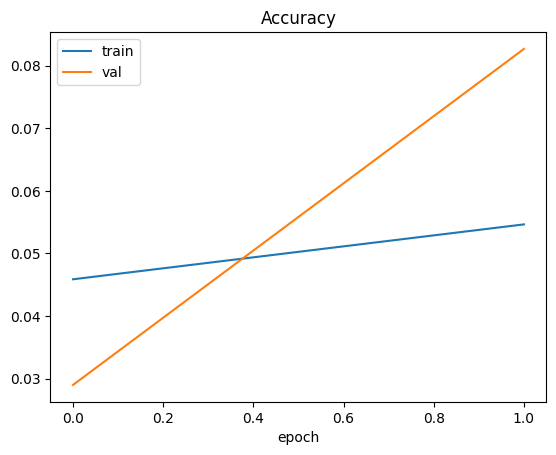

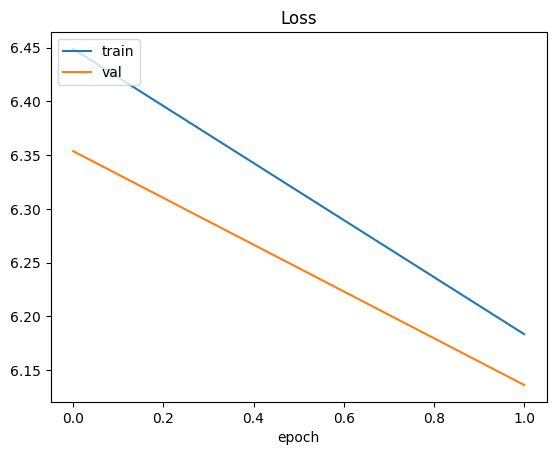

🔮 Prompt: holmes looked at the
💡 Next word predictions: ['of', 'and', 'to', 'i', 'which']


In [2]:
# Install requirements
!pip install nltk keras --quiet

import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

nltk.download('punkt')

print("🔄 Loading and preprocessing...")

# Load a smaller portion of the dataset
import requests
url = 'https://www.gutenberg.org/files/1661/1661-0.txt'
text = requests.get(url).text.lower()
text = text[:100000]  # Trim to first 100,000 chars to save RAM

# Tokenize
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

print("✅ Corpus length:", len(words))

# Unique words
unique_words = sorted(list(set(words)))
unique_word_index = {word: idx for idx, word in enumerate(unique_words)}
word_index_reverse = {idx: word for word, idx in unique_word_index.items()}

# Feature creation
WORD_LENGTH = 5
prev_words = []
next_words = []

for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])

print("✅ Total sequences:", len(prev_words))

# Vectorization (RAM optimized)
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(prev_words), len(unique_words)), dtype=bool)

for i, sequence in enumerate(prev_words):
    for j, word in enumerate(sequence):
        X[i, j, unique_word_index[word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

print("🔢 Vectorized shape:", X.shape)

# Model
model = Sequential()
model.add(LSTM(64, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print("🎓 Training...")
history = model.fit(X, Y, validation_split=0.1, batch_size=128, epochs=2, shuffle=True).history

# Save
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))

# Plot
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# Function to prepare input for prediction
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        if word in unique_word_index:
            x[0, t, unique_word_index[word]] = 1
    return x

# Function to get top N predictions
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

# Predict next word completions
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [list(unique_word_index.keys())[idx] for idx in next_indices]

# Try your own prompt!
prompt = "holmes looked at the"
print(f"🔮 Prompt: {prompt}")
print("💡 Next word predictions:", predict_completions(prompt.lower(), 5))



